__Competition title:__  Home Credit Default Risk

__Project Background:__  The objective was to predict whether a client will default on a loan based on their 
application information, credit card information, etc.

There are 7 tables in total in the data set. The description of all the tables are shown in the following figure

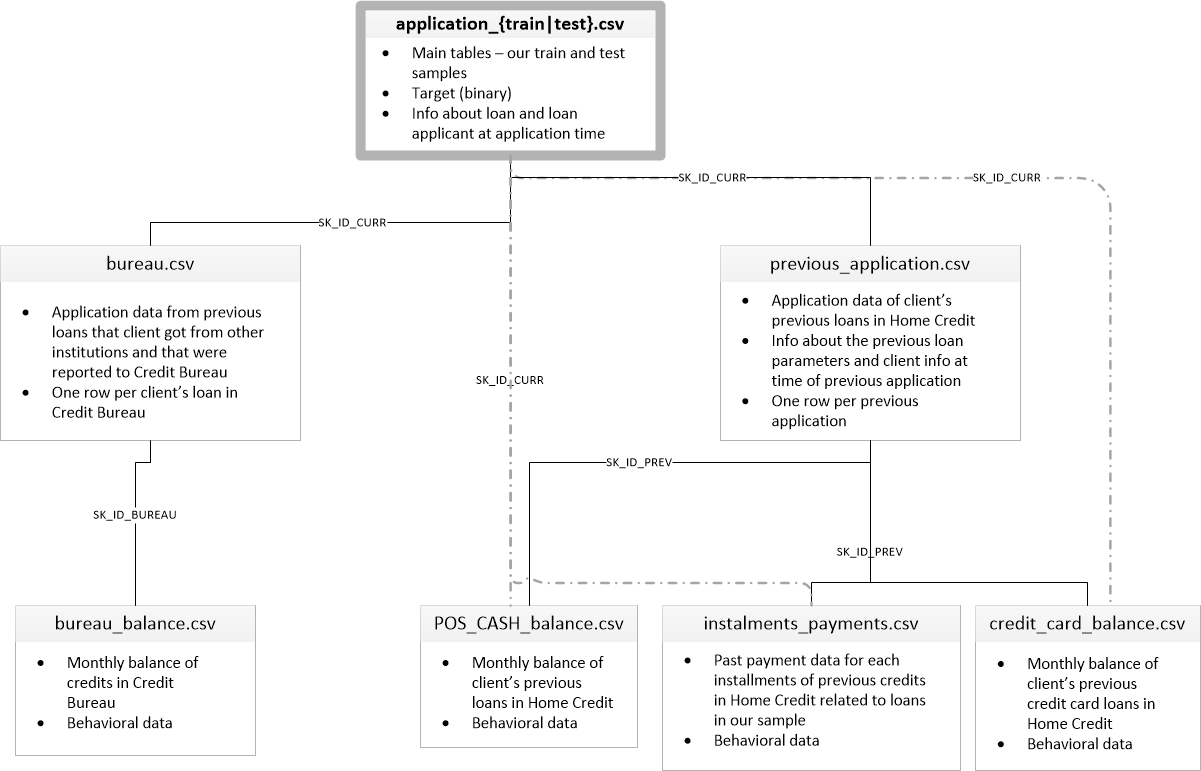

In [1]:
# import some packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import GridSearchCV
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from scipy import stats
from scipy.stats import norm, skew #for some statistics


from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
import gc
import time
from contextlib import contextmanager



In [2]:
app_train= pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

In [3]:
#display all the columns
pd.set_option('max_columns',None)
pd.set_option('max_row',None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00000,406597.50000,24700.50000,351000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01880,-9461,-637,-3648.00000,-2120,nan,1,1,0,1,1,0,Laborers,1.00000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08304,0.26295,0.13938,0.02470,0.03690,0.97220,0.61920,0.01430,0.00000,0.06900,0.08330,0.12500,0.03690,0.02020,0.01900,0.00000,0.00000,0.02520,0.03830,0.97220,0.63410,0.01440,0.00000,0.06900,0.08330,0.12500,0.03770,0.02200,0.01980,0.00000,0.00000,0.02500,0.03690,0.97220,0.62430,0.01440,0.00000,0.06900,0.08330,0.12500,0.03750,0.02050,0.01930,0.00000,0.00000,reg oper account,block of flats,0.01490,"Stone, brick",No,2.00000,2.00000,2.00000,2.00000,-1134.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,100003,0,Cash loans,F,N,N,0,270000.00000,1293502.50000,35698.50000,1129500.00000,Family,State servant,Higher education,Married,House / apartment,0.00354,-16765,-1188,-1186.00000,-291,nan,1,1,0,1,1,0,Core staff,2.00000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31127,0.62225,nan,0.09590,0.05290,0.98510,0.79600,0.06050,0.08000,0.03450,0.29170,0.33330,0.01300,0.07730,0.05490,0.00390,0.00980,0.09240,0.05380,0.98510,0.80400,0.04970,0.08060,0.03450,0.29170,0.33330,0.01280,0.07900,0.05540,0.00000,0.00000,0.09680,0.05290,0.98510,0.79870,0.06080,0.08000,0.03450,0.29170,0.33330,0.01320,0.07870,0.05580,0.00390,0.01000,reg oper account,block of flats,0.07140,Block,No,1.00000,0.00000,1.00000,0.00000,-828.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100004,0,Revolving loans,M,Y,Y,0,67500.00000,135000.00000,6750.00000,135000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / 

# Exploratory Data analysis

## Observe the distribution of the target

<AxesSubplot:xlabel='TARGET', ylabel='count'>

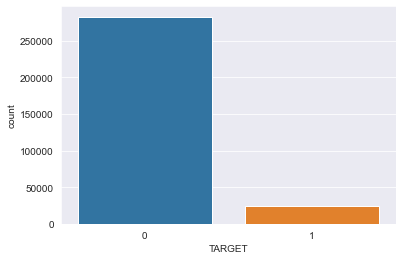

In [5]:
sns.countplot(app_train['TARGET']) 

According to the data set description, target "1" means the clients have difficulties repaying the loan, while target "0" means all other cases.
From the above figure we can see that the number of clients who are unable to repay the loan is far less than the clients who are able to repay the loan. So this is a imbalanced classification problem.

## Observe the missing values

In [6]:
def find_missing_values(data):
    missing_df = data.isnull().sum()
    missing_df = missing_df.drop(missing_df[missing_df == 0].index).sort_values(ascending=False)

    missing_df = pd.DataFrame({'missing_count': missing_df})
    missing_df['missing_rate'] = (missing_df['missing_count'] / len(data)) * 100
    return missing_df
missing_values_table = find_missing_values(app_train)
print("There are {:.0f} features that have missing values".format(len(missing_values_table)))
missing_values_table


There are 67 features that have missing values


,missing_count,missing_rate
COMMONAREA_MEDI,214865,69.87230
COMMONAREA_AVG,214865,69.87230
COMMONAREA_MODE,214865,69.87230
NONLIVINGAPARTMENTS_AVG,213514,69.43296
NONLIVINGAPARTMENTS_MODE,213514,69.43296
NONLIVINGAPARTMENTS_MEDI,213514,69.43296
FONDKAPREMONT_MODE,210295,68.38617
LIVINGAPARTMENTS_AVG,210199,68.35495
LIVINGAPARTMENTS_MEDI,210199,68.35495
LIVINGAPARTMENTS_MODE,210199,68.35495


There are 67 features that have missing values. There are mainly 3 ways to process the missing values:
1. Use the machine learning models like XGBoost that can process missing values automatically.
2. Fill the missing values according to our understanding of the data.
3. remove the features that have too many missing values.

Here I decide to use LightGBM model, so there is no need to process the missing values by my self.

## Find the abnormal data

In [7]:
app_train['DAYS_BIRTH'].head(10)

0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
5   -16941
6   -13778
7   -18850
8   -20099
9   -14469
Name: DAYS_BIRTH, dtype: int64

We can see that all the data in the "DAYS_BIRTH" column are negative values. We need to divide them by -365 to get the clients' ages in years.

In [8]:
YEARS_BIRTH = app_train['DAYS_BIRTH']/-365
YEARS_BIRTH.describe()

count   307511.00000
mean        43.93697
std         11.95613
min         20.51781
25%         34.00822
50%         43.15068
75%         53.92329
max         69.12055
Name: DAYS_BIRTH, dtype: float64

We can see that tha the minimum age is 20.517 agend the maximum age is 69.12. Both of them are normal values. So there are no abnormal values in the "DAYS_BIRTH" column.

In the same way, we can transform the DAYS_EMPLOYED column into YEARS_EMPLOYED column.

In [9]:
YEARS_EMPLOYED = app_train['DAYS_EMPLOYED']/-365
YEARS_EMPLOYED.describe()

count   307511.00000
mean      -174.83574
std        387.05689
min      -1000.66575
25%          0.79178
50%          3.32329
75%          7.56164
max         49.07397
Name: DAYS_EMPLOYED, dtype: float64

We can see that the minimum employed time is -1000 years, which is impossible. By looking at the original data in the 'DAYS_EMPLOYED' column, I see many '365243'. All the values are negative except this value.

Let's look at the data of the clients whose DAYS_EMPLOYED is "'365243'", and find whether there are anything special.

In [10]:
app_train_emp_abnorm = app_train[app_train['DAYS_EMPLOYED'] == 365243]
app_train_emp_norm = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print("There are {:.0f} abnormal data".format(len(app_train_emp_abnorm)))
print("There are {:.0f} normal data".format(len(app_train_emp_norm)))
app_train_emp_abnorm.head(10)

There are 55374 abnormal data
There are 252137 normal data


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
8,100011,0,Cash loans,F,N,Y,0,112500.00000,1019610.00000,33826.50000,913500.00000,Children,Pensioner,Secondary / secondary special,Married,House / apartment,0.01863,-20099,365243,-7427.00000,-3514,nan,1,0,0,1,0,0,NaN,2.00000,2,2,WEDNESDAY,14,0,0,0,0,0,0,XNA,0.58733,0.20575,0.75172,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,1.00000,0.00000,1.00000,0.00000,0.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
11,100015,0,Cash loans,F,N,Y,0,38419.15500,148365.00000,10678.50000,135000.00000,Children,Pensioner,Secondary / secondary special,Married,House / apartment,0.01522,-20417,365243,-5246.00000,-2512,nan,1,0,0,1,1,0,NaN,2.00000,2,2,FRIDAY,7,0,0,0,0,0,0,XNA,0.72204,0.55518,0.65290,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-2396.00000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000
23,100027,0,Cash loans,F,N,Y,0,83250.00000,239850.00000,23850.00000,225000.00000,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.00630,-24827,365243,-9012.00000,-3684,nan,1,0,0,1,1,0,NaN,2.00000,3,3,FRIDAY,12,0,0,0,0,0,0,XNA,nan,0.62430,0.66906,0.14430,0.08480,0.98760,0.83000,0.10640,0.14000,0.12070,0.37500,0.41670,0.23710,0.11730,0.14840,0.00190,0.00070,0.12610,0.07540,0.98760,0.83670,0.00000,0.12080,0.10340,0.37500,0.41670,0.24250,0.11020,0.09230,0.00000,0.00000,0.14570,0.08480,0.98760,0.83230,0.10710,0.14000,0.12070,0.37500,0.41670,0.24120,0.11930,0.15100,0.00

There are 55374 abnormal data, which is a huge number. It seems that those data are quite normal except the "DAYS_EMPLOYED" column. Then let's compare the default ratios of abnormal data and normal data

In [11]:
default_ratio_abnorm = len(app_train_emp_abnorm[app_train_emp_abnorm['TARGET']==1]) / len(app_train_emp_abnorm) 
default_ratio_norm = len(app_train_emp_norm[app_train_emp_norm['TARGET']==1]) / len(app_train_emp_norm)
print("The default ratio of the abnormal data is : {:.3f}%".format(default_ratio_abnorm*100))
print("The default ratio of the normal data is : {:.3f}%".format(default_ratio_norm*100))

The default ratio of the abnormal data is : 5.400%
The default ratio of the normal data is : 8.660%


We can see that the default ratio of the abnormal data is smaller than that of the normal data. But the difference is ralatively small. So it's possible that "365243" is actually the value used to fill the null values. In order not to let this strange value influence the classification accuracy, I decide to replace this strange value with nan.

In [12]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

## Correlation analysis

Next let's find the features that have strong correlation with the target.

In [13]:
corr_target = app_train.corr()['TARGET'].sort_values()

In [14]:
print('The 15 features that have the highest positive correlation with the goal:\n', corr_target.tail(15))
print('The 15 features that have the highest negative correlation with the goal:\n', corr_target.head(15))

The 15 features that have the highest positive correlation with the goal:
 DEF_30_CNT_SOCIAL_CIRCLE      0.03225
LIVE_CITY_NOT_WORK_CITY       0.03252
OWN_CAR_AGE                   0.03761
DAYS_REGISTRATION             0.04197
FLAG_DOCUMENT_3               0.04435
REG_CITY_NOT_LIVE_CITY        0.04440
FLAG_EMP_PHONE                0.04598
REG_CITY_NOT_WORK_CITY        0.05099
DAYS_ID_PUBLISH               0.05146
DAYS_LAST_PHONE_CHANGE        0.05522
REGION_RATING_CLIENT          0.05890
REGION_RATING_CLIENT_W_CITY   0.06089
DAYS_EMPLOYED                 0.07496
DAYS_BIRTH                    0.07824
TARGET                        1.00000
Name: TARGET, dtype: float64
The 15 features that have the highest negative correlation with the goal:
 EXT_SOURCE_3                 -0.17892
EXT_SOURCE_2                 -0.16047
EXT_SOURCE_1                 -0.15532
FLOORSMAX_AVG                -0.04400
FLOORSMAX_MEDI               -0.04377
FLOORSMAX_MODE               -0.04323
AMT_GOODS_PRICE        

We can find that DAYS_BIRTH, DAYS_EMPLOYED have relatively strong positive correlation with the traget. Since DAYS_BIRTH, DAYS_EMPLOYED are both negative values, this positive correlation actually means that: with the increase of clients' age and employed duration, they are less likely to default.  
We can also find that EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3 have relatively strong negative correlation with the traget.This means with the increasing of EXT_SOURCE, the clients are more likely to repay the loan.  
I will explore these important features in detail later.

__age__

In order to see the distribution of ages, I choose to draw a KDE(kernel density estimation) plot.

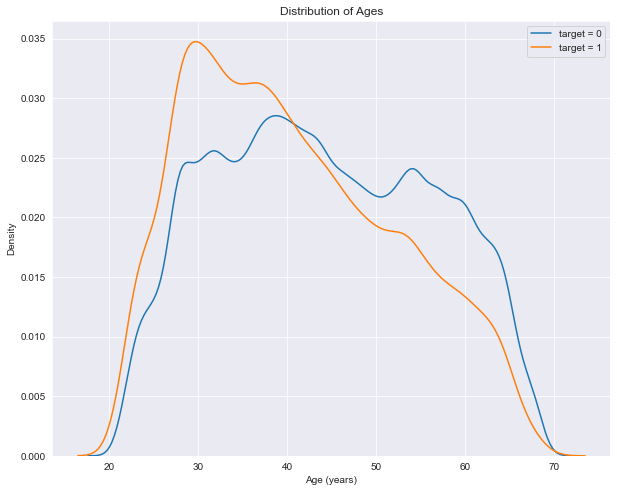

In [15]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target = 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target = 1')

# Labeling of plot
plt.xlabel('Age (years)'); 
plt.ylabel('Density'); 
plt.title('Distribution of Ages');
plt.legend()

The blue line represents the age distribution of those clients who are able to repay, while the orange line represents the age distribution of those clients who are unable to repay.  
As we can see in the kde plot, the orange curve is right skewed, which means the data are more concentrated in the lower age group.  
However, this plot is not intuitive enough, so I decide to divide small age groups and see their default ratio.

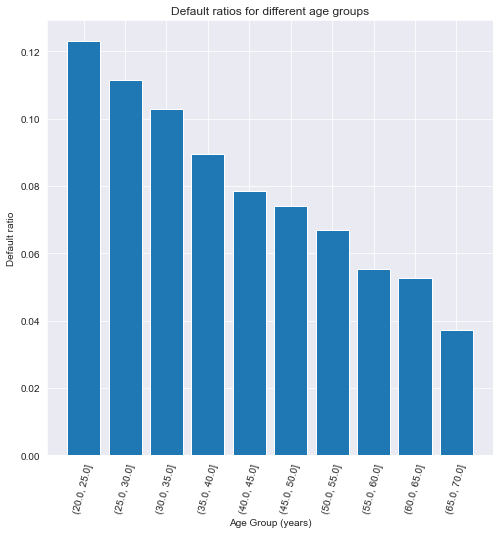

In [16]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Divide the age into 11 bins
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_groups  = age_data.groupby('YEARS_BINNED').mean()

# Bar plot
plt.figure(figsize = (8, 8))
plt.bar(age_groups.index.astype(str), age_groups['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Default ratio')
plt.title('Default ratios for different age groups');

The bar plot is more intuitive than the kda plot. It is clear to see that with the increase of age, the default ratio is decreasing. Since young people are more likely to default, the bank should pay more attention to the young clients and ensure they will not delay repaying the loan.

__Employed duration__

In [17]:
YEARS_EMPLOYED = app_train['DAYS_EMPLOYED']/-365
YEARS_EMPLOYED.describe()

count   252137.00000
mean         6.53197
std          6.40647
min         -0.00000
25%          2.10137
50%          4.51507
75%          8.69863
max         49.07397
Name: DAYS_EMPLOYED, dtype: float64

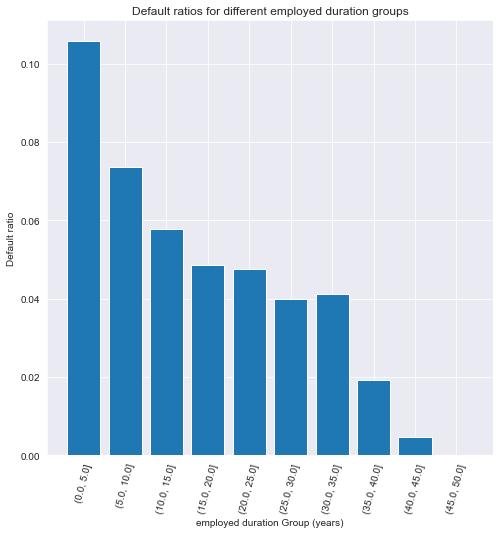

In [18]:
emp_data = app_train[['TARGET', 'DAYS_EMPLOYED']]
emp_data['YEARS_EMPLOYED'] = emp_data['DAYS_EMPLOYED'] / -365

# Divide the age into 11 bins
emp_data['YEARS_BINNED'] = pd.cut(emp_data['YEARS_EMPLOYED'], bins = np.linspace(0, 50, num = 11))
emp_groups  = emp_data.groupby('YEARS_BINNED').mean()

# Bar plot
plt.figure(figsize = (8, 8))
plt.bar(emp_groups.index.astype(str), emp_groups['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('employed duration Group (years)'); plt.ylabel('Default ratio')
plt.title('Default ratios for different employed duration groups');

The employed duration shows a similar trend. The less time the clients are employed, the higher the default ratio is.

__Exterior Sources__

EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3 are normalized scores from 3 different external data sources.

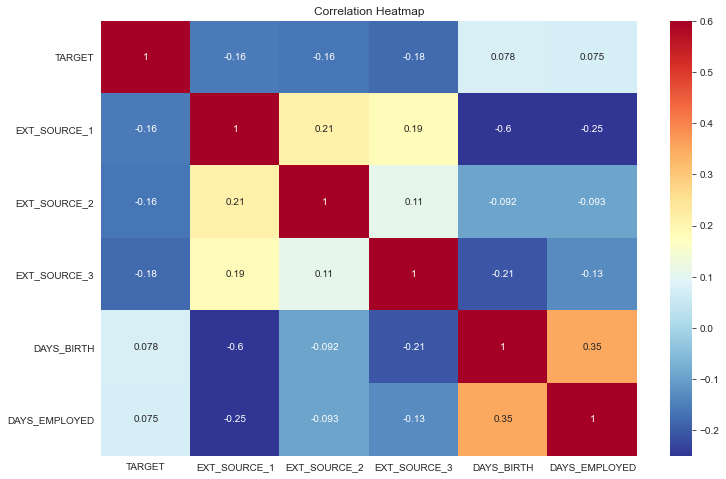

In [19]:
# Explore the correlations between the extra sources
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED']]
ext_data_corrs = ext_data.corr()
plt.figure(figsize = (12, 8))
# Heatmap
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

We can see that the correlation coefficient between the 3 extra sources are between 0.11~0.21, which shows that there is a weak correlation between these three features. The correlation coefficient between EXT_SOURCE_1 and DAYS_BIRTH is as high as -0.6, this may be because the clients' age is one of the key factors of EXT_SOURCE_1. The correlation coefficient between EXT_SOURCE_2 and DAYS_BIRTH is -0.21, indicating that EXT_SOURCE_2 also has weak correlation with the clients' age. However, the correlation coefficient between EXT_SOURCE_2 and DAYS_BIRTH is only 0.092. Which means their correlation is very weak.

# Default clients portrait exploration

In this part, I will analyze more features and explore the default clients' portrait

First define 2 functions to plot figures

In [20]:
def plot_cat_feature(app_train, feature,label_rotation=False,horizontal_layout=True):
    temp = app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Counts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
        
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Counts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Default ratio [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show()

    
def plot_distribution(var):
    
    i = 0
    t1 = app_train.loc[app_train['TARGET'] != 0]
    t0 = app_train.loc[app_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

## Observe the default ratios of different feature values

__Contract type__

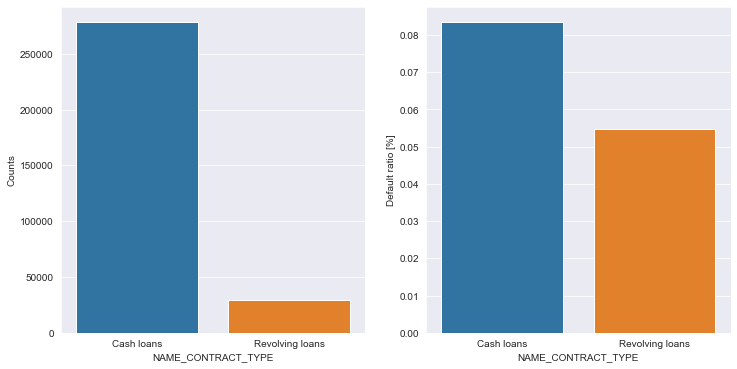

In [21]:
plot_cat_feature(app_train,'NAME_CONTRACT_TYPE')

We can see that the contract type of most of the clients is cash loans, and the default ratios of Cash loans are higher than that of revolving loans.

__Gender__

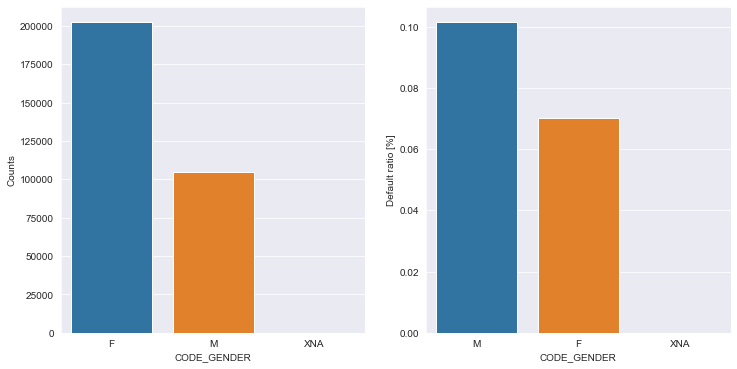

In [22]:
plot_cat_feature(app_train,'CODE_GENDER')

According to the plot, the number of females is around twice of the number of males. However, the default ratio of males is larger than females.

__Whether have a car__

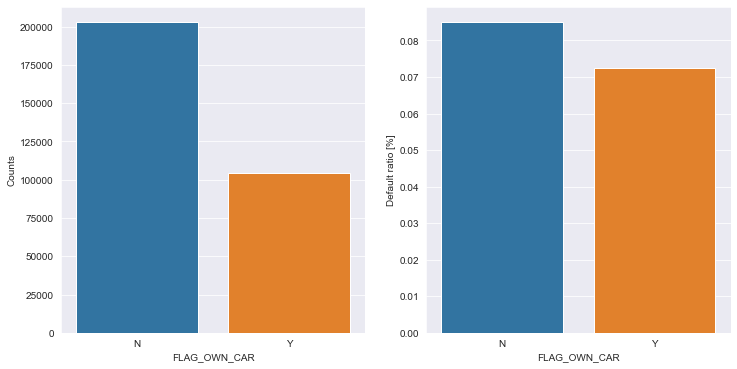

In [23]:
plot_cat_feature(app_train,'FLAG_OWN_CAR')

The number of clients who don't own a car is twice of the number of clients who own a car. And the default ratio of clients who don't own a car is higher than those who own a car. This is easy to explain, because those who own a car generally have better ecnomic situation, which means they are less dependent on loan, and are easier to repay the loan.

__Whether have a realty__

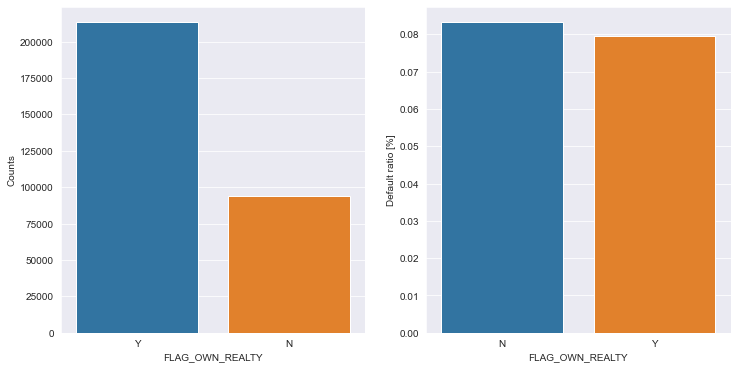

In [24]:
plot_cat_feature(app_train,'FLAG_OWN_REALTY')

The number of clients who don't own a realty is also around twice of the number of clients who own a realty. And the default ratio of clients who don't own a realty is a little bit higher than those who own a realty. Whether someone own a realty also reflects a person's economic situation.Those who own a realty are less dependent on loan, and are easier to repay the loan.

__How many children__

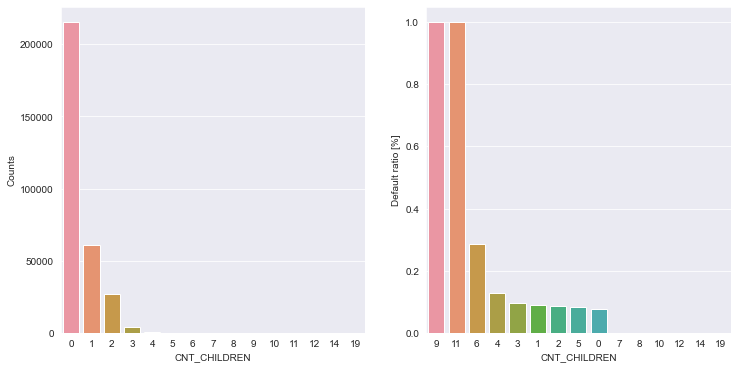

In [25]:
plot_cat_feature(app_train,'CNT_CHILDREN')

We can see that most of the clients have less than 3 childs, and clients who have no child are most prominent. With respect to the default ratio, the default ratios of clients who have 9 and 11 childs are as high as 100%. This may be the coincidence because the samples are really few. By observing the trend, we can see that generally the more childs clients have, the higher the  default ratio is.

__Income source type__

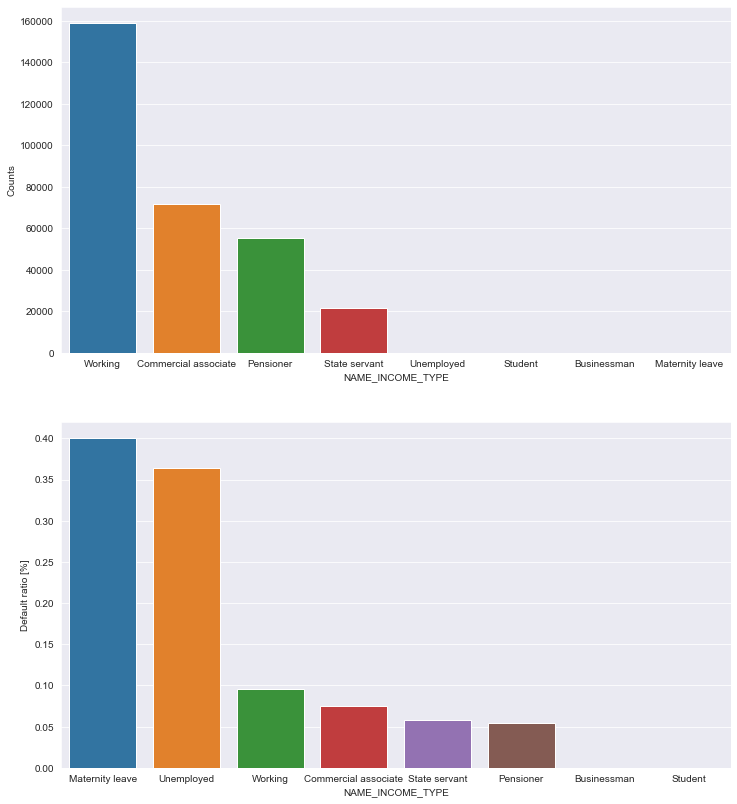

In [26]:
plot_cat_feature(app_train,'NAME_INCOME_TYPE', False, False)

We can see that most of the clients are working, and a protion of clients are working as commercial associate, state servant, or recieving pension.  
The default ratios of clients who are on maternity leave or ware unemployed are very high(more than 35%), while clients of other income types have default ratios lower than 10%. This is easy to interprete, because these two kinds of clients usually have no steady income. But this phenomenon can also be due to coincidence, because These clients are few in number. Let's see the number of these two kinds of clients.

In [27]:
print("There are {:.0f} clients who are on Maternity leave".format(len(app_train[app_train['NAME_INCOME_TYPE']== 'Maternity leave'])))
print("There are {:.0f} clients who are on Maternity leave".format(len(app_train[app_train['NAME_INCOME_TYPE']== 'Unemployed'])))

There are 5 clients who are on Maternity leave
There are 22 clients who are on Maternity leave


It shows that these two kinds of clients are indeed very few. In spite of this. The bank should still be cautious about these two types of clients.

__Education type__

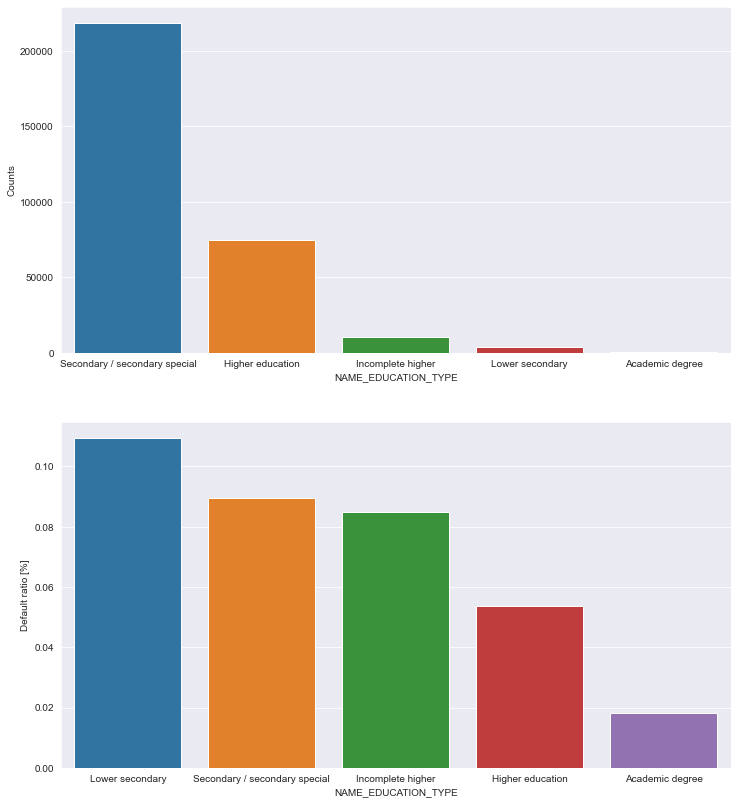

In [28]:
plot_cat_feature(app_train,'NAME_EDUCATION_TYPE', False, False)

As for the highest level of education the clients achieved, the majority of clients only finished secondary school.  
And it's clear to see that generally those who achieve lower level of education have higher possibility of not repaying the loan.

__Family status__

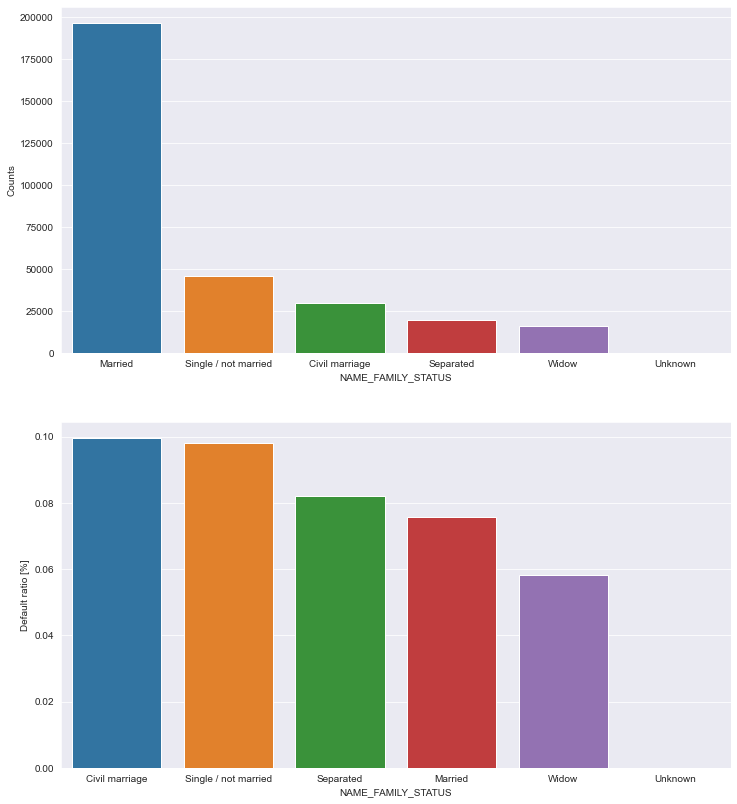

In [29]:
plot_cat_feature(app_train,'NAME_FAMILY_STATUS', False, False)

As for the marriage status of the clients, the majority of clients are already married. The clients who are single or separated or having civil marriage have relatively high default ratio. The widows have the lowest default ratio.  

__Housing type__

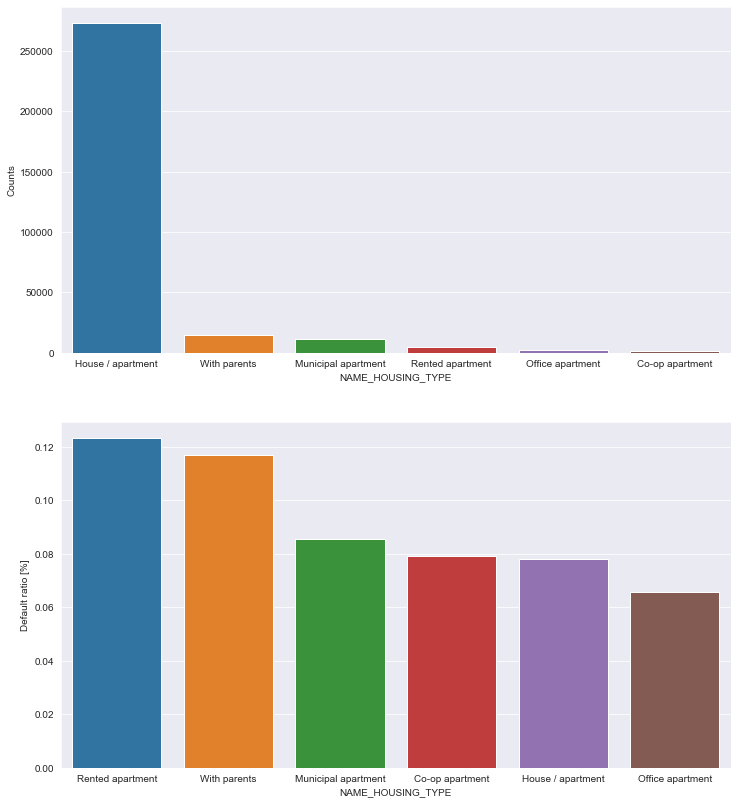

In [30]:
plot_cat_feature(app_train,'NAME_HOUSING_TYPE', False, False)

Most of the clients have houses or apartments. Those who have a house or a apartment shows lower default ratio. In contrast, those who live in a rented apartment or live with their parents have higher default ratio. These clients may have worse economic situation since that they don't have their own houses. Therefore, they are more likely to default.



##  Conclusion
According to the above analysis, we can know the characteristics of defaulting clients:

+ Age

The younger clients are less likely to repay the loan.

+ gender

Males are less likely to repay the loan than females.

+ number of children

The clients who have more children are less likely to repay the loan. Possibly because they have heavier financial burden.


+ years of employment 

The clients who have shorter years of employment are less likely to repay the loan.Possibly because they have fewer savings.

+ income source type

The clients who have relatively stable income source(Like Working, State servant, Pensioner, Commercial associate) are less likely to default.  

+ possession of car and realty

The clients who have a car or realty are less likely to default. possession of car and realty reflects the financial level of a client.

+ education

The clients who receive higher level of education are less likely to default.

+ house type

Those who have a house or a apartment shows lower default ratio. In contrast, those who live in a rented apartment or live with their parents have higher default ratio. These clients may have worse economic situation since that they don't have their own houses.



# Feature engineering

In this part, I will create some new features based on the original features:
* IS_EDUCATION_GOOD

A flag shows whether the client's education is good or not

* IS_INCOME_STABLE

A flag shows whether the client's income is stable or not

* IS_HOUSING_GOOD

A flag shows whether the client's housing is stable or not

* CREDIT_INCOME_PERCENT

Credit amount of the loan / Income of the client

* ANNUITY_INCOME_PERCENT

Loan annuity / Income of the client

* DAYS_EMPLOYED_PERCENT

Employed days / Born days

* INCOME_PER_CHILD

Income of the client / number of children

In [31]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

def create_new_feat(app_data):
    app_data['IS_EDUCATION_GOOD'] = app_data['NAME_EDUCATION_TYPE'].map({      
    'Secondary / secondary special' : 0,
    'Lower secondary' : 0, 
    'Incomplete higher' : 0,
    'Higher education' : 1,
    'Academic degree' : 1,
        })

    app_data['IS_INCOME_STABLE'] = app_data['NAME_INCOME_TYPE'].map({      
    'Maternity leave': 0,
    'Unemployed': 0,
    'Working' : 1,
    'Commercial associate': 1,
    'State servant': 1,
    'Pensioner': 1,
    'Businessman': 1,
    'Student': 1
        })

    app_data['IS_HOUSING_GOOD'] = app_data['NAME_HOUSING_TYPE'].map({      
    'Rented apartment': 0,
    'With parents': 0,
    'Municipal apartment': 1,
    'Co-op apartment': 1,
    'House / apartment': 1,
    'Office apartment': 1
    })

    app_data['CREDIT_INCOME_PERCENT'] = app_data['AMT_CREDIT'] / app_data['AMT_INCOME_TOTAL']
    app_data['ANNUITY_INCOME_PERCENT'] = app_data['AMT_ANNUITY'] / app_data['AMT_INCOME_TOTAL']
    app_data['CREDIT_TERM'] = app_data['AMT_ANNUITY'] / app_data['AMT_CREDIT']
    app_data['DAYS_EMPLOYED_PERCENT'] = app_data['DAYS_EMPLOYED'] / app_data['DAYS_BIRTH']
    
    
create_new_feat(app_train_domain)
create_new_feat(app_test_domain)


Let's see the distribution of the newly created features in defaulting clients and non-defaulting clients.

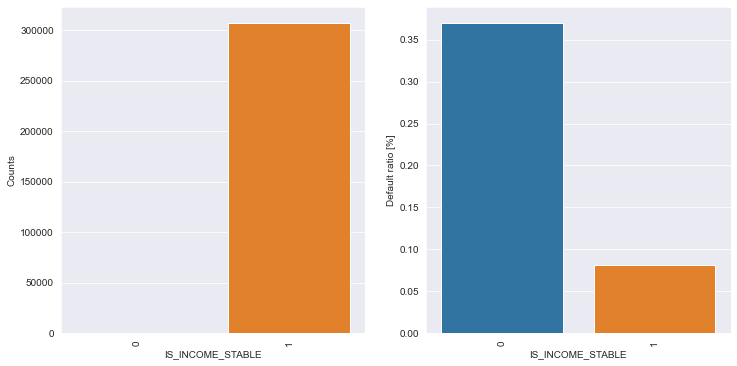

In [32]:
plot_cat_feature(app_train_domain, 'IS_INCOME_STABLE', True)

We can see that the default rate of clients whose "IS_INCOME_STABLE" is 0 is much larger than that of clients whose "IS_INCOME_STABLE" is 1. It seems that this feature can distinguish defaulting clients and non-defaulting clients well. But the number of clients whose "IS_INCOME_STABLE" is 1 is much bigger that the number of clients whose "IS_INCOME_STABLE" is 0, so the effectiveness of this feature remains to be seen.

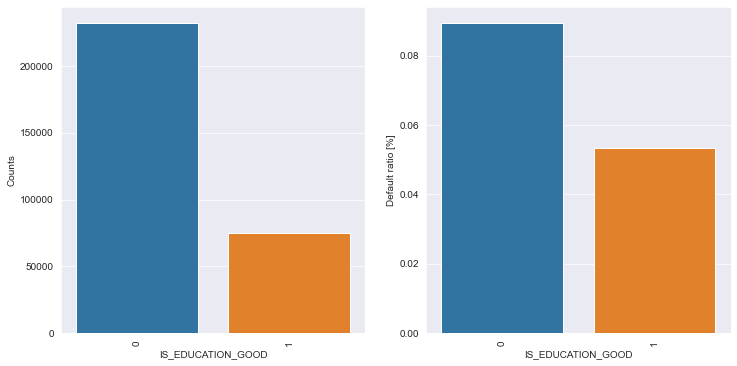

In [33]:
plot_cat_feature(app_train_domain, 'IS_EDUCATION_GOOD', True)

We can see that the default rate of clients whose "IS_EDUCATION_STABLE" is 0 is much larger than that of clients whose "IS_INCOME_STABLE" is 1. This shows that the clients who have recieved good education are more likely to repay the loan.It seems that this is a good feature to distinguish defaulting clients and non-defaulting clients.

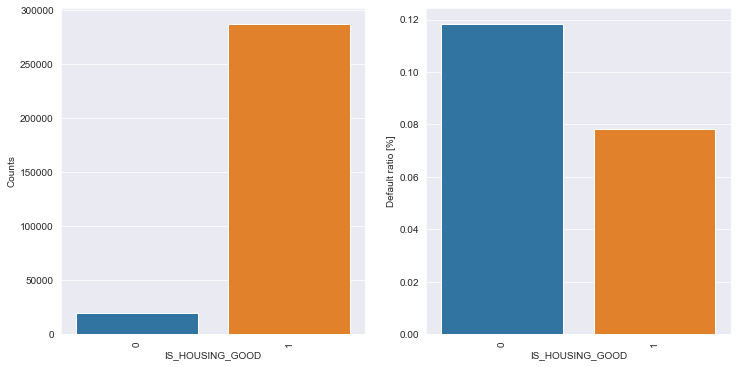

In [34]:
plot_cat_feature(app_train_domain, 'IS_HOUSING_GOOD', True)

We can see that the default rate of clients whose "IS_HOUSING_GOOD" is 0 is much larger than that of clients whose "IS_HOUSING_GOOD" is 1. This shows that the clients who have relatively good housing condition are more likely to repay the loan. It seems that this is a good feature to distinguish defaulting clients and non-defaulting clients.

For the numerical features, we can plot the kde plots to see the distribution of those features for different target values.

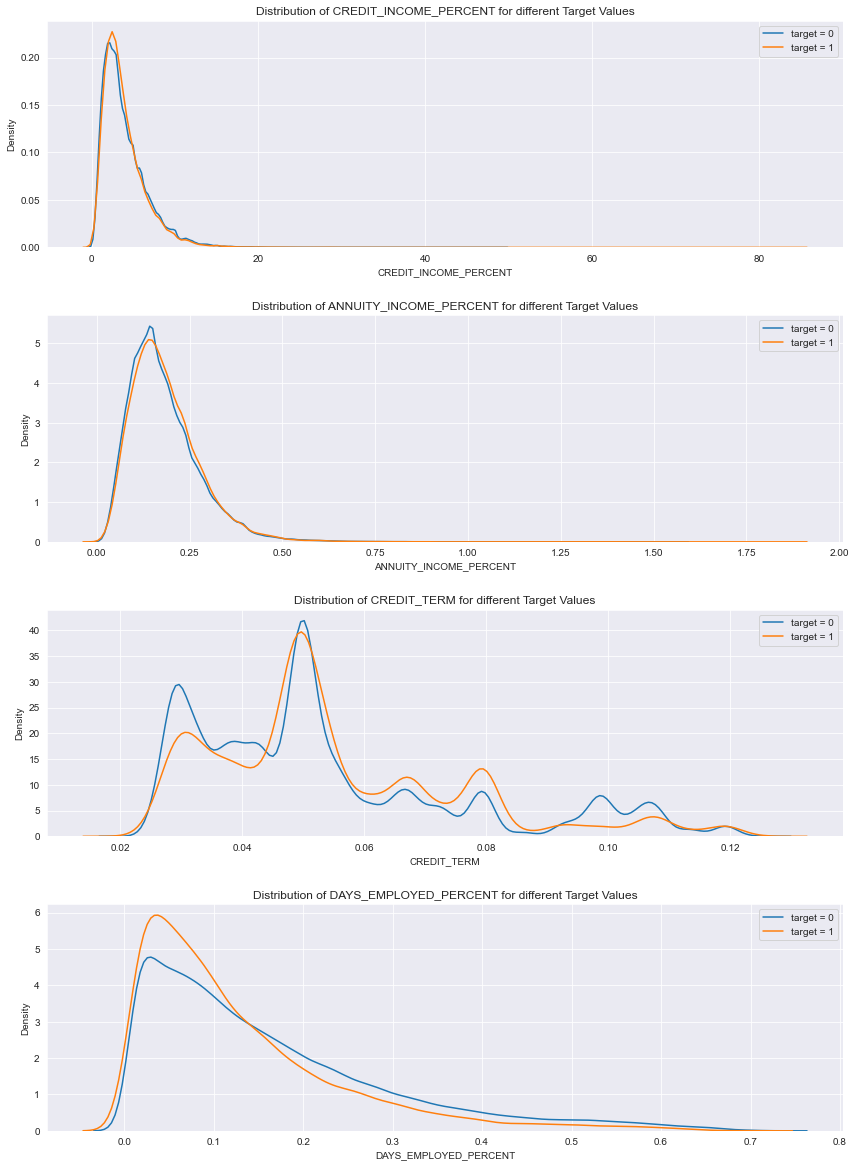

In [35]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(5, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target = 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target = 1')
    
    # Label the plots
    plt.title('Distribution of %s for different Target Values' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.legend()
plt.tight_layout(h_pad = 2.5)


We can see that the distribution of  'CREDIT_INCOME_PERCENT' and 'ANNUITY_INCOME_PERCENT' by Target Values only shows small differences. 
And the distribution of 'CREDIT_TERM' and 'DAYS_EMPLOYED_PERCENT' shows relatively bigger differences.

Next, let's see the correlations between the new features and the target.

In [36]:
corr_target = app_train_domain.corr()['TARGET'].sort_values()
print('The top 20 features that have the highest positive correlation with the target:\n', corr_target.tail(20))
print('The top 20 features that have the highest negative correlation with the target:\n', corr_target.head(20))

The top 20 features that have the highest positive correlation with the target:
 ANNUITY_INCOME_PERCENT        0.01427
CNT_CHILDREN                  0.01919
AMT_REQ_CREDIT_BUREAU_YEAR    0.01993
FLAG_WORK_PHONE               0.02852
DEF_60_CNT_SOCIAL_CIRCLE      0.03128
DEF_30_CNT_SOCIAL_CIRCLE      0.03225
LIVE_CITY_NOT_WORK_CITY       0.03252
OWN_CAR_AGE                   0.03761
DAYS_REGISTRATION             0.04197
FLAG_DOCUMENT_3               0.04435
REG_CITY_NOT_LIVE_CITY        0.04440
FLAG_EMP_PHONE                0.04598
REG_CITY_NOT_WORK_CITY        0.05099
DAYS_ID_PUBLISH               0.05146
DAYS_LAST_PHONE_CHANGE        0.05522
REGION_RATING_CLIENT          0.05890
REGION_RATING_CLIENT_W_CITY   0.06089
DAYS_EMPLOYED                 0.07496
DAYS_BIRTH                    0.07824
TARGET                        1.00000
Name: TARGET, dtype: float64
The top 20 features that have the highest negative correlation with the target:
 EXT_SOURCE_3                 -0.17892
EXT_SOURCE_

In [37]:
print('correlation with target for IS_INCOME_STABLE:  ', corr_target['IS_INCOME_STABLE'] )
print('correlation with target for IS_EDUCATION_GOOD:  ', corr_target['IS_EDUCATION_GOOD'] )
print('correlation with target for IS_HOUSING_GOOD:  ', corr_target['IS_HOUSING_GOOD'] )
print('correlation with target for CREDIT_INCOME_PERCENT:  ', corr_target['CREDIT_INCOME_PERCENT'] )
print('correlation with target for ANNUITY_INCOME_PERCENT:  ', corr_target['ANNUITY_INCOME_PERCENT'] )
print('correlation with target for DAYS_EMPLOYED_PERCENT:  ', corr_target['DAYS_EMPLOYED_PERCENT'] )

correlation with target for IS_INCOME_STABLE:   -0.009963120018905739
correlation with target for IS_EDUCATION_GOOD:   -0.0568352958430899
correlation with target for IS_HOUSING_GOOD:   -0.036298351993908254
correlation with target for CREDIT_INCOME_PERCENT:   -0.007726797322315164
correlation with target for ANNUITY_INCOME_PERCENT:   0.014265220698075357
correlation with target for DAYS_EMPLOYED_PERCENT:   -0.06795454075829058


We can see that among the new features, DAYS_EMPLOYED_PERCENT,  IS_EDUCATION_GOOD,  IS_HOUSING_GOOD,  ANNUITY_INCOME_PERCENT have relatively stronger correlations with the target. They are listed in the top 20 features that have the highest correlation with the target.

# Modelling and Prediction

In [38]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
import gc

In [39]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    
    #Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [40]:
submission, fi, metrics = model(app_train_domain, app_test_domain)
print('Baseline metrics')
print(metrics)

# del app_train_domain,app_test_domain
# gc.collect

Training Data Shape:  (307511, 248)
Testing Data Shape:  (48744, 248)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.804318	train's binary_logloss: 0.541747	valid's auc: 0.762105	valid's binary_logloss: 0.55755
[400]	train's auc: 0.833537	train's binary_logloss: 0.511715	valid's auc: 0.762631	valid's binary_logloss: 0.539228
Early stopping, best iteration is:
[358]	train's auc: 0.828093	train's binary_logloss: 0.517504	valid's auc: 0.76289	valid's binary_logloss: 0.542611
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.804049	train's binary_logloss: 0.542184	valid's auc: 0.765939	valid's binary_logloss: 0.558066
[400]	train's auc: 0.833997	train's binary_logloss: 0.511441	valid's auc: 0.766275	valid's binary_logloss: 0.539454
Early stopping, best iteration is:
[304]	train's auc: 0.820507	train's binary_logloss: 0.525363	valid's auc: 0.766565	valid's binary_logloss: 0.54792
Training until validation scores don't im

In [41]:
del app_train_domain,app_test_domain
gc.collect

<function gc.collect(generation=2)>

In [42]:
submission.to_csv('submission_lightGBM_1sheet.csv',index=False)

In [43]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

# del app_train,app_test
# gc.collect

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.798776	train's binary_logloss: 0.547732	valid's auc: 0.755301	valid's binary_logloss: 0.563583
[400]	train's auc: 0.828115	train's binary_logloss: 0.518495	valid's auc: 0.755183	valid's binary_logloss: 0.54559
Early stopping, best iteration is:
[330]	train's auc: 0.818572	train's binary_logloss: 0.528099	valid's auc: 0.755925	valid's binary_logloss: 0.551344
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.798672	train's binary_logloss: 0.547978	valid's auc: 0.758343	valid's binary_logloss: 0.563566
Early stopping, best iteration is:
[289]	train's auc: 0.812801	train's binary_logloss: 0.533928	valid's auc: 0.758486	valid's binary_logloss: 0.555106
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.79771	train's binary_logloss: 0.549295	valid's auc: 0.763002	valid's bi

In [44]:
submission.to_csv('submission_lightGBM_1sheet_without_fea.csv',index=False)

As we can see, after adding new features, the accuracy is higher. But the accuracy is not satisfactory enough, we need to make use of the information in other data sets.

# Merge all the data sets

In [45]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## application_train_test.csv

The preprocessing contents for this data set has been explained above.
The preprocessing steps contains:
1. Merge data set 'application_train.csv' and 'application_test.csv' 
2. Create some new features
3. Use null values to fill the abnormal values in 'DAYS_EMPLOYED'
4. Use one-hot encoding to encode the categorical features

In [46]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    
    df['NEW_IS_EDUCATION_GOOD'] = df['NAME_EDUCATION_TYPE'].map({      
    'Secondary / secondary special' : 0,
    'Lower secondary' : 0, 
    'Incomplete higher' : 0,
    'Higher education' : 1,
    'Academic degree' : 1,
        })

    df['NEW_IS_INCOME_STABLE'] = df['NAME_INCOME_TYPE'].map({      
    'Maternity leave': 0,
    'Unemployed': 0,
    'Working' : 1,
    'Commercial associate': 1,
    'State servant': 1,
    'Pensioner': 1,
    'Businessman': 1,
    'Student': 1
        })

    df['NEW_IS_HOUSING_GOOD'] = df['NAME_HOUSING_TYPE'].map({      
    'Rented apartment': 0,
    'With parents': 0,
    'Municipal apartment': 1,
    'Co-op apartment': 1,
    'House / apartment': 1,
    'Office apartment': 1
    })

    df['NEW_CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['NEW_ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['NEW_CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['NEW_DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_INCOME_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NEW_IS_EDUCATION_GOOD',
'NEW_IS_INCOME_STABLE', 'NEW_IS_HOUSING_GOOD']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    del test_df
    gc.collect()
    return df

## bureau.csv and bureau_balance.csv

The preprocessing steps contains:
1. Perform One-hot encoding to the categorical features in 'bureau.csv' and 'bureau_balance.csv'.
1. Perform aggregations on bureau_balance.csv by feature 'SK_ID_BUREAU' and then merge it with bureau.csv
2. Perform aggregations on the merged data set by feature 'SK_ID_CURR'

In [47]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['count', 'mean', 'max', 'min', 'sum'],
        'DAYS_CREDIT_ENDDATE': ['count', 'mean', 'max', 'min', 'sum'],
        'DAYS_CREDIT_UPDATE': ['count', 'mean', 'max', 'min', 'sum'],
        'CREDIT_DAY_OVERDUE': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_CREDIT_MAX_OVERDUE': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_CREDIT_SUM': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_ANNUITY': ['count', 'mean', 'max', 'min', 'sum'],
        'CNT_CREDIT_PROLONG': ['count', 'mean', 'max', 'min', 'sum'],
        'MONTHS_BALANCE_MIN': ['count', 'mean', 'max', 'min', 'sum'],
        'MONTHS_BALANCE_MAX': ['count', 'mean', 'max', 'min', 'sum'],
        'MONTHS_BALANCE_SIZE': ['count', 'mean', 'max', 'min', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: 
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat: 
        cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    del bureau

    gc.collect()
    return bureau_agg

## previous_applications.csv

The preprocessing steps contains:
1. Perform One-hot encoding to the categorical features in 'previous_application.csv'
2. Use null values to fill the abnormal values 365243
3. Create some new features
4. Perform aggregations on the data set by feature 'SK_ID_CURR'

In [48]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # 365243 is a abnormal value, replace it by null
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_APPLICATION': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_CREDIT': ['count', 'mean', 'max', 'min', 'sum'],
        'APP_CREDIT_PERC': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_DOWN_PAYMENT': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_GOODS_PRICE': ['count', 'mean', 'max', 'min', 'sum'],
        'HOUR_APPR_PROCESS_START':['count', 'mean', 'max', 'min', 'sum'],
        'RATE_DOWN_PAYMENT': ['count', 'mean', 'max', 'min', 'sum'],
        'DAYS_DECISION': ['count', 'mean', 'max', 'min', 'sum'],
        'CNT_PAYMENT': ['count', 'mean', 'max', 'min', 'sum']
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    del prev
    gc.collect()
    return prev_agg

##  POS_CASH_balance.csv

The preprocessing steps contains:
1. Perform One-hot encoding to the categorical features in 'POS_CASH_balance.csv'
2. Use null values to fill the abnormal values 365243
3. Create some new features
4. Perform aggregations on the data set by feature 'SK_ID_CURR'

In [49]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['count', 'mean', 'max', 'min', 'sum'],
        'SK_DPD': ['count', 'mean', 'max', 'min', 'sum'],
        'SK_DPD_DEF':['count', 'mean', 'max', 'min', 'sum'],
        'CNT_INSTALMENT': ['count', 'mean', 'max', 'min', 'sum'],
        'CNT_INSTALMENT_FUTURE' : ['count', 'mean', 'max', 'min', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

##  installments_payments.csv

The preprocessing steps contains:
1. Perform One-hot encoding to the categorical features in 'installments_payments.csv'
2. Create some new features
3. Perform aggregations on the data set by feature 'SK_ID_CURR'

In [50]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Create some new features
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['count', 'mean', 'max', 'min', 'sum'],
        'DBD': ['count', 'mean', 'max', 'min', 'sum'],
        'PAYMENT_PERC': ['count', 'mean', 'max', 'min', 'sum'],
        'PAYMENT_DIFF': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_INSTALMENT': ['count', 'mean', 'max', 'min', 'sum'],
        'AMT_PAYMENT': ['count', 'mean', 'max', 'min', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['count', 'mean', 'max', 'min', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

## Preprocess credit_card_balance.csv

The preprocessing steps contains:
1. Perform One-hot encoding to the categorical features in 'installments_payments.csv'
2. Perform aggregations on the data set by feature 'SK_ID_CURR'

In [51]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg([ 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

## Modelling and prediction

In [52]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            #is_unbalance=True,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            #scale_pos_weight=11
            )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [53]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [54]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 105)
Process bureau and bureau_balance - done in 10s
Previous applications df shape: (338857, 209)
Process previous_applications - done in 26s
Pos-cash balance df shape: (337252, 36)
Process POS-CASH balance - done in 19s
Installments payments df shape: (339587, 37)
Process installments payments - done in 39s
Credit card balance df shape: (103558, 113)
Process credit card balance - done in 19s
Starting LightGBM. Train shape: (307511, 758), test shape: (48744, 758)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858298	training's binary_logloss: 0.209327	valid_1's auc: 0.792425	valid_1's binary_logloss: 0.237336
Early stopping, best iteration is:
[1357]	training's auc: 0.87528	training's binary_logloss: 0.201939	valid_1's auc: 0.793121	valid_1's binary_logloss: 0.236997
Fold  1 AUC : 0.793121
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.

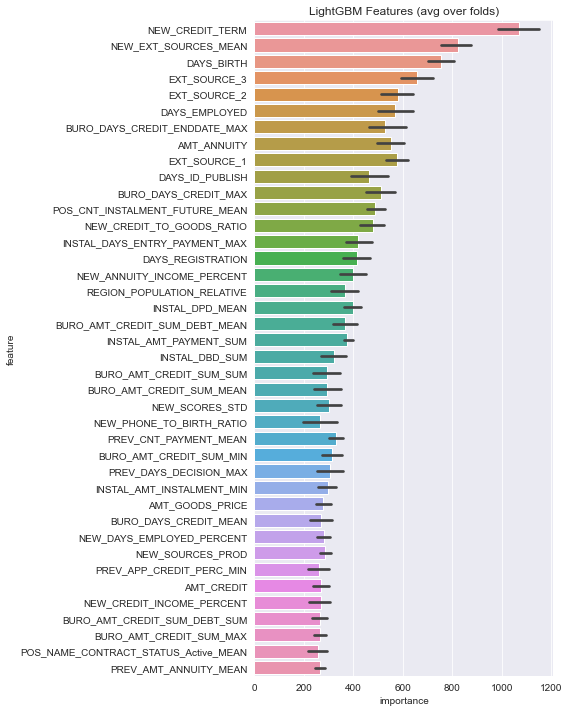

In [55]:
if __name__ == "__main__":
    submission_file_name = "submission_mix_app_my_fork_forks.csv"
    with timer("Full model run"):
        main()